In [1]:
from matplotlib import pyplot as plt
import numpy as np

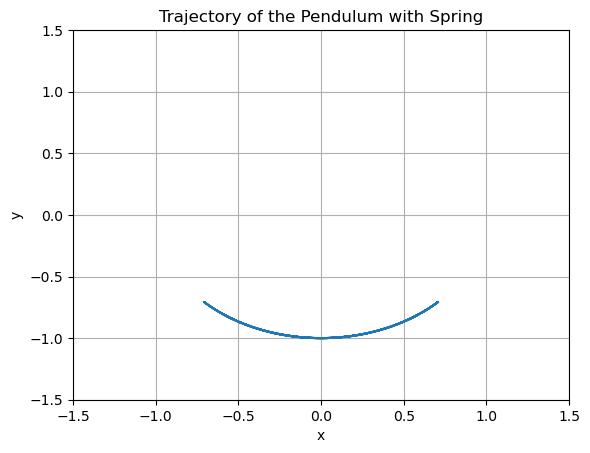

array([[ 0.70710678, -0.70710678],
       [ 0.70710678, -0.70711659],
       [ 0.70710629, -0.70713572],
       ...,
       [-0.58466712, -0.81146936],
       [-0.5858156 , -0.81062203],
       [-0.58695566, -0.80977284]])

In [11]:
# Constants
g = 9.81  # Gravitational acceleration (positive value for downward)
m = 0.1  # Mass of the pendulum
l0 = 1  # Natural length of the spring
dt = 0.001  # Time step
t_max = 5  # Total simulation time
k = 10000  # Spring constant

# Number of steps
n = int(t_max / dt)

# Arrays to store values
a = np.zeros((n, 2))
v = np.zeros((n, 2))
x = np.zeros((n, 2))
t = np.zeros(n)

# Initial conditions
x[0] = [0.5**0.5, -0.5**0.5]

# Simulation loop
for i in range(n - 1):
    l = np.sqrt(x[i][0]**2 + x[i][1]**2)
    # Calculate the spring force magnitude
    F_s = - k * (l - l0)

    # Normalize the direction vector
    dir_x = x[i][0] / l # sin(theta)
    dir_y = x[i][1] / l # cos(theta)
    
    sigmaF = np.array([dir_x * F_s, dir_y * F_s - m * g])

    # Update acceleration
    a[i + 1] = sigmaF / m

    # Update velocity
    v[i + 1] = v[i] + dt * a[i + 1]

    # Update position
    x[i + 1] = x[i] + dt * v[i + 1]

    # Update time
    t[i + 1] = t[i] + dt

# Plotting the trajectory
plt.plot(x[:, 0], x[:, 1])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of the Pendulum with Spring')
plt.grid(True)
plt.show()
x

## Double Pendulum Simulation

<img alt="Huygens&amp;#39; double pendulum experiment" height="882" src="https://scx2.b-cdn.net/gfx/news/2016/eindhovenand.jpg" width="1440"/>

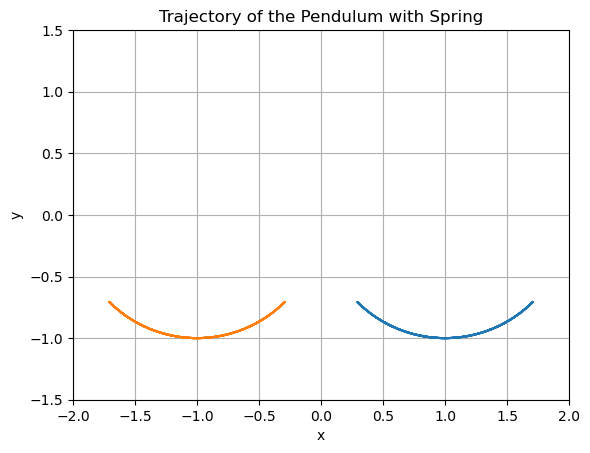

array([[ 1.70710678, -0.70710678],
       [ 1.70710678, -0.70711659],
       [ 1.7071058 , -0.70713523],
       ...,
       [ 0.41513728, -0.81119559],
       [ 0.41399044, -0.81034805],
       [ 0.41284777, -0.80950456]])

In [13]:
# Constants
g = 9.81  # Gravitational acceleration (positive value for downward)
m = 0.1  # Mass of the pendulum
l0 = 4  # Natural length of the springs - a sum of the three springs in the system
dt = 0.001  # Time step
t_max = 5  # Total simulation time
k = 10000  # Spring constant

# Number of steps
n = int(t_max / dt)

# Arrays to store values
t = np.zeros(n)
a = np.zeros((n, 2))
v = np.zeros((n, 2))
x = np.zeros((n, 2))

a2 = np.zeros((n, 2))
v2 = np.zeros((n, 2))
x2 = np.zeros((n, 2))

# Initial conditions
x[0] = [0.5**0.5 + 1, -0.5**0.5]
x2[0] = [-0.5**0.5 - 1, -0.5**0.5]

# Simulation loop
for i in range(n - 1):
    l = np.sqrt((x[i][0] - 1)**2 + x[i][1]**2)
    l2 = np.sqrt((x2[i][0] + 1)**2 + x2[i][1]**2)
    l_total = l + l2 + 2
    
    # Calculate the spring force magnitude
    F_s = - k * (l_total - l0)
    F_s2 = - k * (l_total - l0)

    # Normalize the direction vector
    dir_x = (x[i][0] - 1) / l # sin(theta)
    dir_y = x[i][1] / l # cos(theta)

    dir_x2 = (x2[i][0] + 1) / l # sin(theta)
    dir_y2 = x2[i][1] / l2 # cos(theta)

    sigmaF = np.array([dir_x * F_s, dir_y * F_s - m * g])

    sigmaF2 = np.array([dir_x2 * F_s2, dir_y2 * F_s2 - m * g])

    # Update acceleration
    a[i + 1] = sigmaF / m
    a2[i + 1] = sigmaF2 / m

    # Update velocity
    v[i + 1] = v[i] + dt * a[i + 1]
    v2[i + 1] = v2[i] + dt * a2[i + 1]

    # Update position
    x[i + 1] = x[i] + dt * v[i + 1]
    x2[i + 1] = x2[i] + dt * v2[i + 1]

    # Update time
    t[i + 1] = t[i] + dt

# Plotting the trajectory
plt.plot(x[:, 0], x[:, 1])
plt.plot(x2[:, 0], x2[:, 1])
plt.xlim(-2,2)
plt.ylim(-1.5,1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of the Pendulum with Spring')
plt.grid(True)
plt.show()
x